## 0. 라이브러리 / 기본셋업


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
import os

버전 확인

- `python` >= 3.10.12
- `numpy` >= 1.26.0
- `pandas` >= 2.1.1
- `matplotlib` >= 3.8.1
- `seaborn` >= 0.13.0
- `missingno` >= 0.5.2

In [86]:
import sys, matplotlib

print("="*5 ,"나의 라이브러리 버전 확인", "="*5)
print(f"{'python version':15s} <> {sys.version}")
print(f"{'numpy version':15s} <> {np.__version__}")
print(f"{'pandas version':15s} <> {pd.__version__}")
print(f"{'matplotlib version':15s} <> {matplotlib.__version__}")
print(f"{'seaborn version':15s} <> {sns.__version__}")
print(f"{'missingno version':15s} <> {msno.__version__}")

===== 나의 라이브러리 버전 확인 =====
python version  <> 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
numpy version   <> 1.26.3
pandas version  <> 2.1.4
matplotlib version <> 3.8.0
seaborn version <> 0.13.1
missingno version <> 0.5.2


# 데이터셋

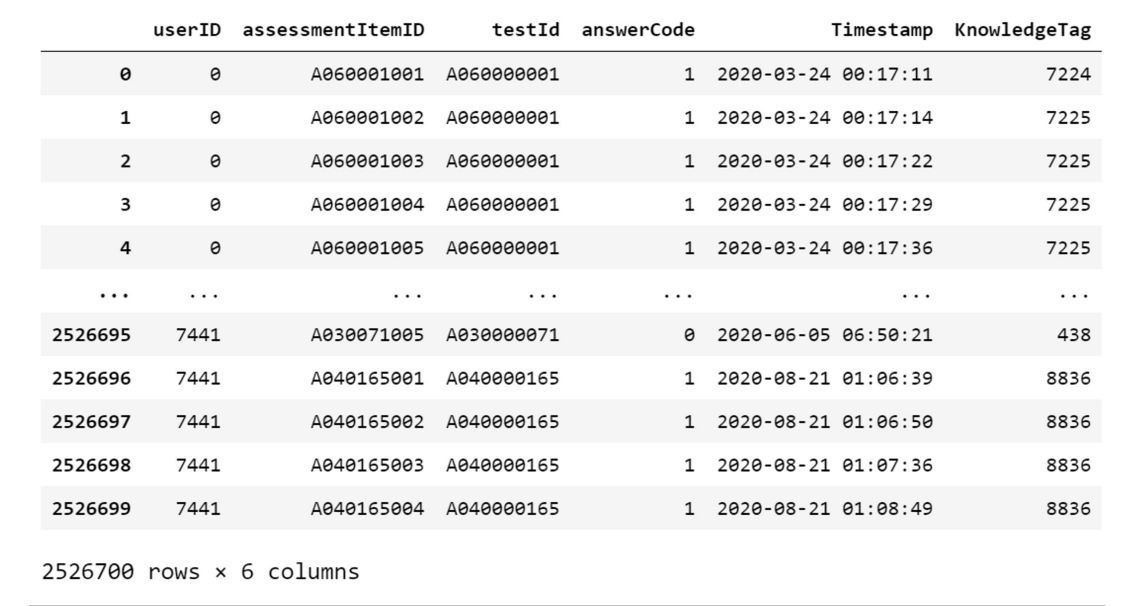

**userID**

총 7,442명의 고유한 사용자 존재

**assessmentItemID **

총 9,454개의 고유한 문항이 존재

**test**

총 1,537개의 고유한 시험지

**answerCode**

사용자가 문항을 맞았는지 여부를 담은 이진 데이터

**Timestamp**

사용자가 Interaction을 시작한 시간 정보

**KnowledgeTag**

총 912개의 고유 태그


In [87]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}

# Data load
data_path = "/data/ephemeral/level2-dkt-recsys-06/data/"

train = pd.read_csv(data_path + 'train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
test = pd.read_csv(data_path + 'test_data.csv', dtype=dtype, parse_dates=['Timestamp'])

CPU times: user 3.35 s, sys: 126 ms, total: 3.48 s
Wall time: 3.49 s


In [88]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [89]:
test.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623


In [90]:
# merge data
df_filtered = test[test['answerCode'] != -1]
train = pd.concat([train, df_filtered], axis=0)
train = train.sort_values(by=["userID", "Timestamp"]).reset_index(drop=True)

# 정답률에 평균을 사용할 예정이기에 -1인 answer code는 0.5로 변환, 추후에 다시 복구할 예정
# train['answerCode'] = train['answerCode'].apply(lambda x: 0.5 if x == -1 else x)

# 0) 자료형 변환
데이터 크기가 커지는 것을 방지하기 위하여 중복된 정보를 제거하였다.

## 1.'assessmentItemID' 변환
A 제거하고 시험번호 및 문제번호만 남김

In [91]:
def process_assessmentItemID(df, input_col='assessmentItemID', output_col='assessmentItemID'):
    df_copy = df.copy()
    df_copy[output_col] = df_copy[input_col].str[1:]
    return df_copy

# 함수 적용
train = process_assessmentItemID(train)
test = process_assessmentItemID(test)

## 2.'testId' 변환
열에서 2~ 4과 8~ 10 남김(시험번호)

In [92]:
def process_testId(df, input_col='testId', output_col='testId'):
    df_copy = df.copy()
    df_copy[output_col] = df_copy[input_col].apply(lambda x: x[1:4] + x[7:])
    return df_copy

# 함수 적용
train = process_testId(train)
test = process_testId(test)

## 결과확인

In [93]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,060001001,060001,1,2020-03-24 00:17:11,7224
1,0,060001002,060001,1,2020-03-24 00:17:14,7225
2,0,060001003,060001,1,2020-03-24 00:17:22,7225
3,0,060001004,060001,1,2020-03-24 00:17:29,7225
4,0,060001005,060001,1,2020-03-24 00:17:36,7225


# 1) Feature 생성

## 1.SolvingTime, CumulativeTime 생성
 해당 문제를 푸는데 걸린 시간(초), 해당 시험지 내에서 해당 문제 전까지 누적 풀이 시간(초)

In [94]:
def add_solving_time(df):
    df['NextTimestamp'] = pd.to_datetime(df.groupby(['userID', 'testId'])['Timestamp'].shift(-1))
    df['SolvingTime'] = (df['NextTimestamp'] - df['Timestamp']).dt.total_seconds()
    df['CumulativeTime'] = df.groupby(['userID', 'testId'])['SolvingTime'].cumsum()
    df = df.drop(columns=['NextTimestamp'])
    return df

train = add_solving_time(train)
test = add_solving_time(test)

## Issue : 시험지 내 마지막 문제에 Solvingtime 결측

## 시각화를 통한 EDA 결과 확인

/tmp/ipykernel_100324/3730884394.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_answer_rate = train.loc[time_bin.index].groupby(time_bin)['answerCode'].mean()


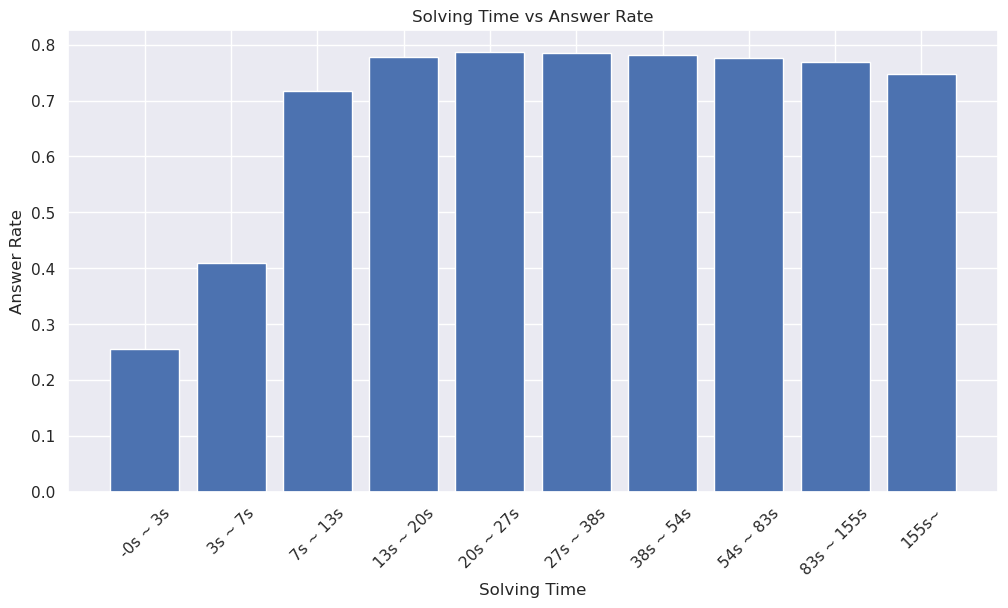

In [95]:
# SolvingTime에 따른 정답률 시각화
df_no_nan = train['SolvingTime'].dropna()
quantiles = df_no_nan.quantile(np.arange(0, 1.1, 0.1)) # 상위 0~10% 풀이시간부터 90~100%까지 10분위로 나눔
time_bin = pd.cut(df_no_nan, bins=quantiles, include_lowest=True)
bin_answer_rate = train.loc[time_bin.index].groupby(time_bin)['answerCode'].mean()
bin_labels = ["{:.0f}s ~ {:.0f}s".format(bin.left, bin.right) for bin in bin_answer_rate.index.categories[:-1]]
bin_labels.append("{:.0f}s~".format(bin_answer_rate.index.categories[-1].left))

plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(len(bin_answer_rate)), height=bin_answer_rate.values, tick_label=bin_labels)
plt.xlabel('Solving Time')
plt.ylabel('Answer Rate')
plt.title('Solving Time vs Answer Rate')
plt.xticks(rotation=45)
plt.show()

결과 해석 : 0~7초 (풀이시간 하위 20%)의 풀이 시간을 가질 경우 오답 비율이 굉장히 높았다. 찍었다는 의미

## 2.Month, DayOfWeek, TimeOfDay
문제를 푼 달, 요일, 시간대(0~ 6시는 새벽, 6~ 12시는 오전, 12~ 18시는 오후, 18~ 24시는 밤)

In [96]:
def process_timestamp(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Month'] = df['Timestamp'].dt.month
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
    day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    df['DayOfWeek'] = df['DayOfWeek'].map(day_dict)

    def label_hour(hour):
        if 0 <= hour < 6:
            return 'Dawn'
        elif 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        else:
            return 'Night'

    df['TimeOfDay'] = df['Timestamp'].dt.hour.apply(label_hour)
    return df

train = process_timestamp(train)
test = process_timestamp(test)


## 시각화를 통한 EDA 결과 확인

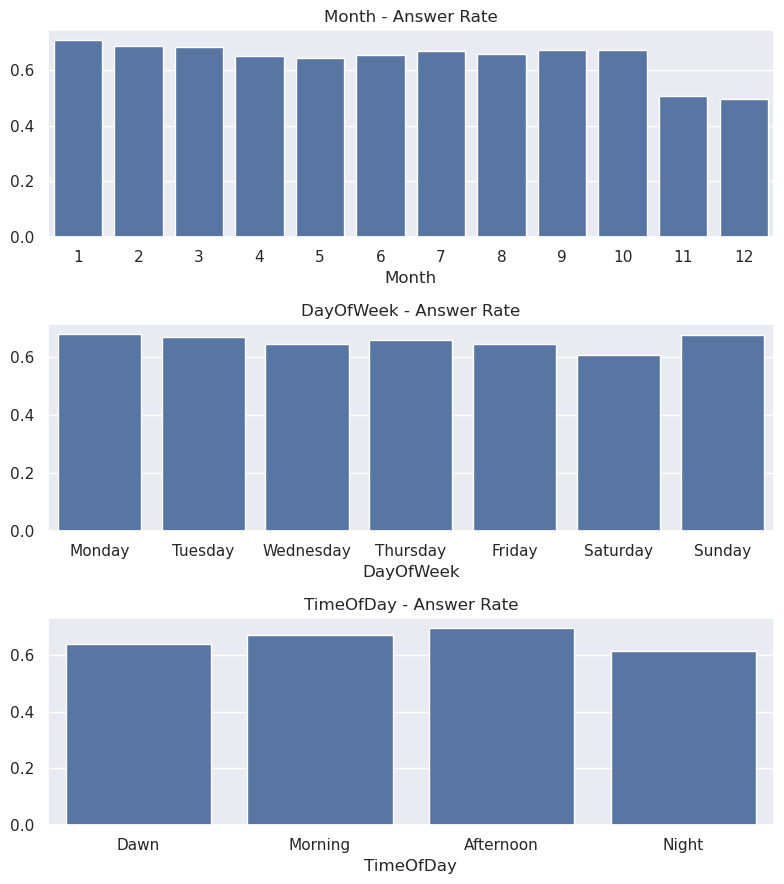

In [97]:
# 각 달에 따른 정답률 계산
month_answer_rate = train.groupby('Month')['answerCode'].mean()

# 각 요일에 따른 정답률 계산
day_answer_rate = train.groupby('DayOfWeek')['answerCode'].mean()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_answer_rate = day_answer_rate.loc[day_order]

# 시간대에 따른 정답률 계산
time_answer_rate = train.groupby('TimeOfDay')['answerCode'].mean()
time_order = ["Dawn", "Morning", "Afternoon", "Night"]
time_answer_rate = time_answer_rate.loc[time_order]
fig, ax = plt.subplots(3, 1, figsize=(8, 9))

sns.barplot(x=month_answer_rate.index, y=month_answer_rate.values, ax=ax[0])
ax[0].set_title('Month - Answer Rate')

sns.barplot(x=day_answer_rate.index, y=day_answer_rate.values, ax=ax[1])
ax[1].set_title('DayOfWeek - Answer Rate')

sns.barplot(x=time_answer_rate.index, y=time_answer_rate.values, ax=ax[2])
ax[2].set_title('TimeOfDay - Answer Rate')

plt.tight_layout()
plt.show()

결과 해석 : 11, 12월의 정답률이 눈에 띄게 낮음, 밤과 새벽보단 오전, 오후 정답률이 대체로 높음, 요일은 정답률에 영향을 거의 주지 않음

## 3.User: problems_last7days, problems_last30days, problems_cumulative Cumulative_User_Problem_Answer_Rate 생성
User가 해당 문제 푼 시점으로부터 7일 전까지, 30일 전까지, 처음까지 푼 누적 문제 수, 처음까지 푼 누적 문제 정답률

In [98]:
def add_problem_statistics(df):
    df = df.sort_values(['userID', 'Timestamp'])
    grouped = df.groupby('userID')
    df['problems_cumulative'] = grouped.cumcount()

    results = []
    for name, group in grouped:
        group['problems_last7days'] = group.rolling('7D', on='Timestamp')['assessmentItemID'].count() - 1
        group['problems_last30days'] = group.rolling('30D', on='Timestamp')['assessmentItemID'].count() - 1
        results.append(group)

    df = pd.concat(results)
    df['problems_last7days'] = df['problems_last7days'].astype(int)
    df['problems_last30days'] = df['problems_last30days'].astype(int)

    return df

train = add_problem_statistics(train)
test = add_problem_statistics(test)


## 시각화를 통한 EDA 결과 확인

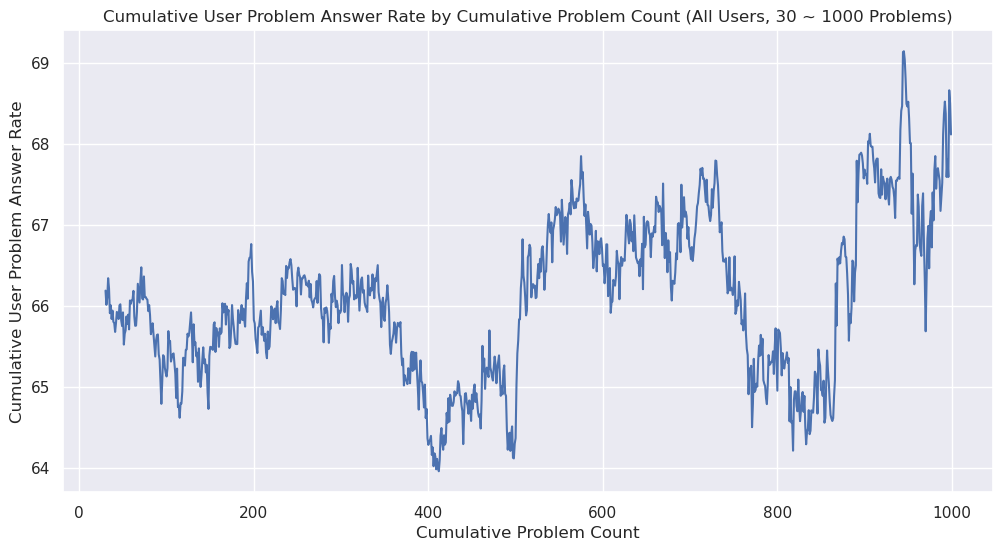

In [99]:
# 누적 풀이 문제수에 따른 정답률 추이 (30문제 이하, 1000문제 이상 제외)
train['CumulativeUserProblemAnswerRate'] = (train.groupby('userID')['answerCode'].transform(lambda x: x.expanding().mean().shift(fill_value=0.5) * 100).astype(int))
train['CumulativeProblemCount'] = train.groupby('userID').cumcount()
selected_df = train[(train['CumulativeProblemCount'] >= 30) & (train['CumulativeProblemCount'] < 1000)]

test['CumulativeUserProblemAnswerRate'] = (test.groupby('userID')['answerCode'].transform(lambda x: x.expanding().mean().shift(fill_value=0.5) * 100).astype(int))
test['CumulativeProblemCount'] = train.groupby('userID').cumcount()
selected_df = test[(test['CumulativeProblemCount'] >= 30) & (test['CumulativeProblemCount'] < 1000)]

plt.figure(figsize=(12, 6))
plt.plot(selected_df.groupby('CumulativeProblemCount')['CumulativeUserProblemAnswerRate'].mean())
plt.xlabel('Cumulative Problem Count')
plt.ylabel('Cumulative User Problem Answer Rate')
plt.title('Cumulative User Problem Answer Rate by Cumulative Problem Count (All Users, 30 ~ 1000 Problems)')
plt.show()

결과 해석 : 누적 문제 풀이 숫자가 증가할수록 대체로 정답률이 의미있게 증가함을 확인

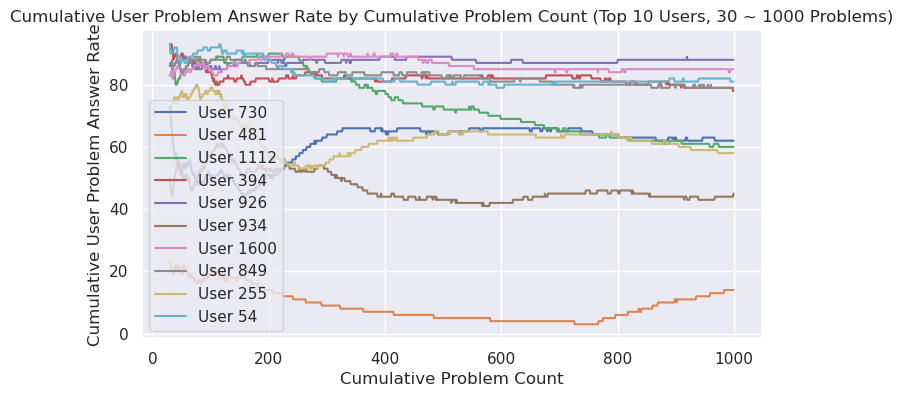

In [100]:
# 문제 풀이 수 상위 10명의 누적 문제풀이 개수별 정답률 추이
top10_users = train['userID'].value_counts().index[:10]

plt.figure(figsize=(8, 4))
for user in top10_users:
    user_df = train[train['userID'] == user]
    selected_user_df = user_df[(user_df['CumulativeProblemCount'] >= 30) & (user_df['CumulativeProblemCount'] < 1000)]
    plt.plot(selected_user_df['CumulativeProblemCount'], selected_user_df['CumulativeUserProblemAnswerRate'], label='User {}'.format(user))

plt.xlabel('Cumulative Problem Count')
plt.ylabel('Cumulative User Problem Answer Rate')
plt.title('Cumulative User Problem Answer Rate by Cumulative Problem Count (Top 10 Users, 30 ~ 1000 Problems)')
plt.legend()
plt.show()

문제 풀이 수 Top 10 유저들의 누적 문제 풀이 별 누적 정답률 그래프. 위의 그래프와 다르게 상승 경향성을 확인하기 힘들다.

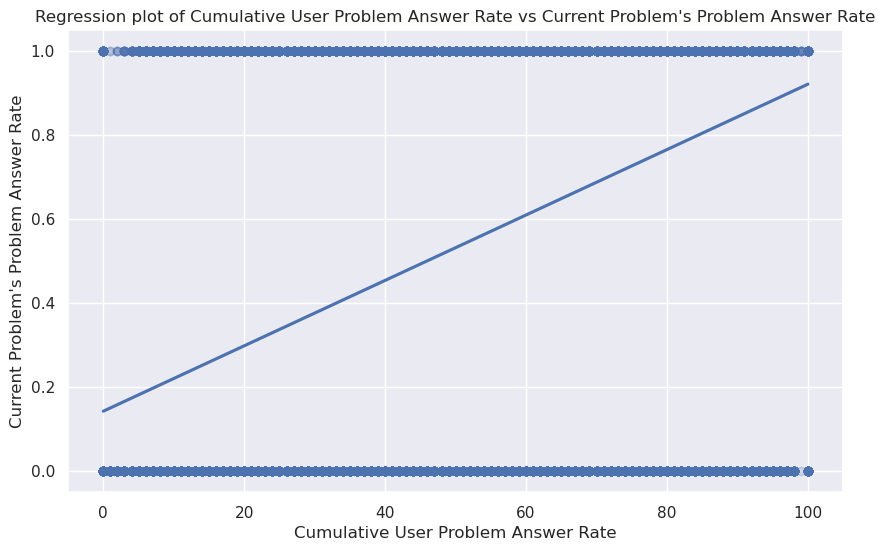

In [101]:
# 이용자의 누적 정답률에 따른 현재 문제의 정답률 회귀선.

plt.figure(figsize=(10, 6))
sns.regplot(x='CumulativeUserProblemAnswerRate', y='answerCode', data=train, scatter_kws={'alpha':0.05})
plt.title('Regression plot of Cumulative User Problem Answer Rate vs Current Problem\'s Problem Answer Rate')
plt.xlabel('Cumulative User Problem Answer Rate')
plt.ylabel('Current Problem\'s Problem Answer Rate')
plt.show()

## 4.문제별 정답률 생성
해당 문제의 정답률 생성

In [102]:
def add_answer_rate_of_item(df):
    # answerCode가 1인 경우는 정답이므로 1, 그 외의 경우는 0으로 표시하여 새로운 열 추가
    df['ProblemAnswerRate'] = df['answerCode'].eq(1).astype(int)

    # 각 assessmentItemID 별로 정답률 계산하여 새로운 열 추가
    df['ProblemAnswerRate'] = (df.groupby('assessmentItemID')['ProblemAnswerRate'].transform('mean') * 100).astype(int)
    return df

# 함수 적용
train = add_answer_rate_of_item(train)
test = add_answer_rate_of_item(test)



## 5.Tag 정답률 생성
해당 문제의 Tag별 정답률 생성

In [103]:
def add_tag_answerRate(df):
    # KnowledgeTag별 정답률 계산
    tag_AnswerRate = df.groupby('KnowledgeTag')['answerCode'].mean()

    df['TagAnswerRate'] = (df['KnowledgeTag'].map(tag_AnswerRate) * 100).astype(int)
    return df

train = add_tag_answerRate(train)
test = add_tag_answerRate(test)

## 6.User의 Tag 기준 과거 정답률

In [104]:
def add_cumulative_user_tag_answer_rate(df):
    df['CumulativeUserTagAnswerRate'] = (df.groupby(['userID', 'KnowledgeTag'])['answerCode'].transform(lambda x: x.expanding().mean().shift(fill_value=0.5) * 100).astype(int))

    return df

train = add_cumulative_user_tag_answer_rate(train)
test = add_cumulative_user_tag_answer_rate(test)

## 7.Test 정답률 생성


In [105]:
def add_test_answer_rate_column(df):
    # 'testId'를 기준으로 'answerCode'의 평균을 계산
    test_avg = df.groupby('testId')['answerCode'].mean()

    df['TestAnswerRate'] = (df['testId'].map(test_avg) * 100).astype(int)
    return df

train = add_test_answer_rate_column(train)
test = add_test_answer_rate_column(test)

## 결과확인

In [106]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,SolvingTime,CumulativeTime,Month,DayOfWeek,TimeOfDay,problems_cumulative,problems_last7days,problems_last30days,CumulativeUserProblemAnswerRate,CumulativeProblemCount,ProblemAnswerRate,TagAnswerRate,CumulativeUserTagAnswerRate,TestAnswerRate
0,0,060001001,060001,1,2020-03-24 00:17:11,7224,3.0,3.0,3,Tuesday,Dawn,0,0,0,50,0,98,95,50,95
1,0,060001002,060001,1,2020-03-24 00:17:14,7225,8.0,11.0,3,Tuesday,Dawn,1,1,1,100,1,96,91,50,95
2,0,060001003,060001,1,2020-03-24 00:17:22,7225,7.0,18.0,3,Tuesday,Dawn,2,2,2,100,2,91,91,100,95
3,0,060001004,060001,1,2020-03-24 00:17:29,7225,7.0,25.0,3,Tuesday,Dawn,3,3,3,100,3,97,91,100,95
4,0,060001005,060001,1,2020-03-24 00:17:36,7225,11.0,36.0,3,Tuesday,Dawn,4,4,4,100,4,94,91,100,95


# 2) 결측치

## 1.SolvingTime이 결측치 채우기
SolvingTime이 결측일 때 해당 유저의 해당 시험의 평균 걸린 시간으로 채워준다

In [107]:
# EDA전 SolvingTime 열의 결측치 확인
missing_solving_time = train['SolvingTime'].isnull().sum()

print(f"EDA전 SolvingTime 열의 결측치 개수: {missing_solving_time}")

EDA전 SolvingTime 열의 결측치 개수: 407189


In [108]:
def fill_missing_solving_time(df):
    grouped = df.groupby(['userID', 'testId'])['SolvingTime'].transform('mean')
    df['SolvingTime'] = df['SolvingTime'].fillna(grouped)
    df['SolvingTime'] = df['SolvingTime'].astype(int)

    return df

train = fill_missing_solving_time(train)
test = fill_missing_solving_time(test) 

In [109]:
# EDA후 SolvingTime 열의 결측치 확인
missing_solving_time = train['SolvingTime'].isnull().sum()

print(f"EDA후 SolvingTime 열의 결측치 개수: {missing_solving_time}")

EDA후 SolvingTime 열의 결측치 개수: 0


## 2.CumulativeTime 결측치
SolvingTime이 결측 채운것을 바탕으로 CumulativeTime 결측치를 채운다.

In [110]:
# EDA전 CumulativeTime 열의 결측치 확인
missing_CumulativeTime = train['CumulativeTime'].isnull().sum()

print(f"EDA전 CumulativeTime 열의 결측치 개수: {missing_CumulativeTime}")

EDA전 CumulativeTime 열의 결측치 개수: 407189


In [111]:
def fill_missing_CumulativeTime(df):
    # 결측값이 있는 행을 선택
    missing_CumulativeTime_rows = df[df['CumulativeTime'].isnull()]

    # 결측값이 있는 행에 대해 루프 수행
    for index, row in missing_CumulativeTime_rows.iterrows():
        # 이전 행의 CumulativeTime가져오기
        prev_cumulative_time = df.at[index - 1, 'CumulativeTime']

        # 현재 행의 solving_time 가져오기
        solving_time = df.at[index, 'SolvingTime']

        # CumulativeTime 갱신
        CumulativeTime = prev_cumulative_time +solving_time

        # SolvingTime 값을 해당 행에 채워 넣기
        df.at[index, 'CumulativeTime'] = CumulativeTime

    df['CumulativeTime'] = df['CumulativeTime'].astype(int)
    return df

train = fill_missing_CumulativeTime(train)
test = fill_missing_CumulativeTime(test)

In [112]:
# EDA후 CumulativeTime 열의 결측치 확인
missing_CumulativeTime = train['CumulativeTime'].isnull().sum()

print(f"EDA후 CumulativeTime 열의 결측치 개수: {missing_CumulativeTime}")

EDA후 CumulativeTime 열의 결측치 개수: 0



# 3) 범주화

## 1.SolvingTime 범주화
SolvingTime 열을 10분위로 범주화해서 새로 열 생성

In [113]:
def categorize_solving_time(df):
    # SolvingTime 열을 10분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_solvingTime'] = pd.qcut(df['SolvingTime'], q=10, labels=False)

    return df

train = categorize_solving_time(train)
test = categorize_solving_time(test)

## 2.문제 난이도 범주화
범주화해서 새로 열 생성

In [114]:
def categorize_ProblemAnswerRate(df):
    # CorrectnessRate 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_ProblemAnswerRate'] = pd.qcut(df['ProblemAnswerRate'], q=7, labels=['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy'])
    return df

train = categorize_ProblemAnswerRate(train)
test = categorize_ProblemAnswerRate(test) 

## 시각화를 통한 EDA 결과 확인

/tmp/ipykernel_100324/1335839608.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_answer_rate = train.groupby('categorize_ProblemAnswerRate')['answerCode'].mean()


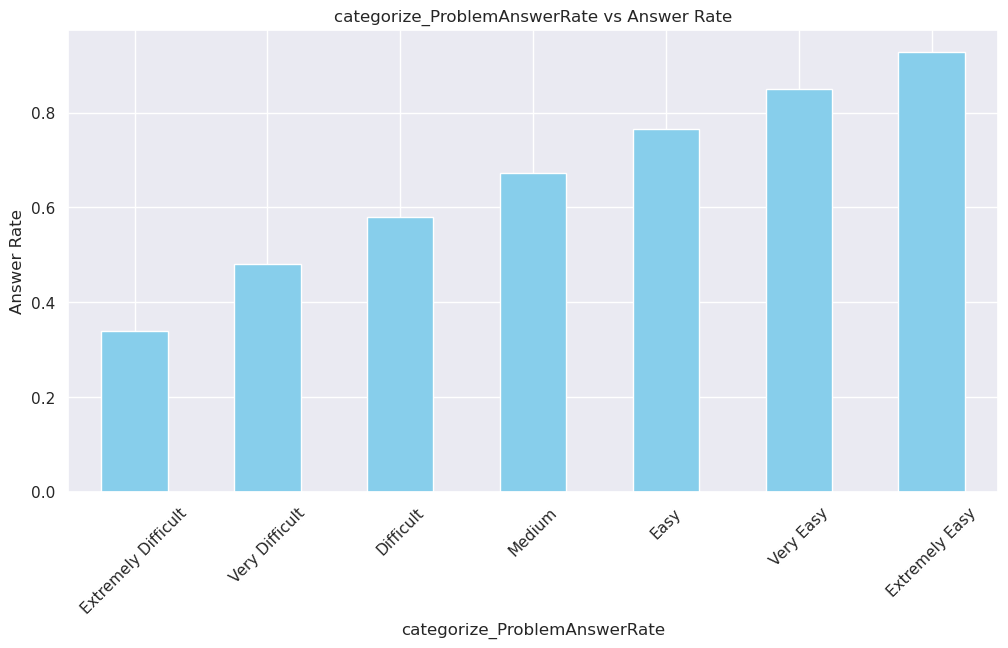

In [115]:
# 범주별 정답률 계산
category_answer_rate = train.groupby('categorize_ProblemAnswerRate')['answerCode'].mean()
difficulty = ['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy']
category_answer_rate = category_answer_rate.loc[difficulty]


# 그래프 시각화
plt.figure(figsize=(12, 6))
category_answer_rate.plot(kind='bar', color='skyblue')
plt.xlabel('categorize_ProblemAnswerRate')
plt.ylabel('Answer Rate')
plt.title('categorize_ProblemAnswerRate vs Answer Rate')
plt.xticks(rotation=45)

plt.show()

## 3.Tag 난이도 범주화
범주화해서 새로 열 생성

In [116]:
def categorize_TagCorrectnessRate(df):
    # TagAnswerRate 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_TagAnswerRate'] = pd.qcut(df['TagAnswerRate'], q=7, labels=['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy'])

    return df

train = categorize_TagCorrectnessRate(train)
test = categorize_TagCorrectnessRate(test)  

/tmp/ipykernel_100324/3853415987.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_answer_rate = train.groupby('categorize_TagAnswerRate')['answerCode'].mean()


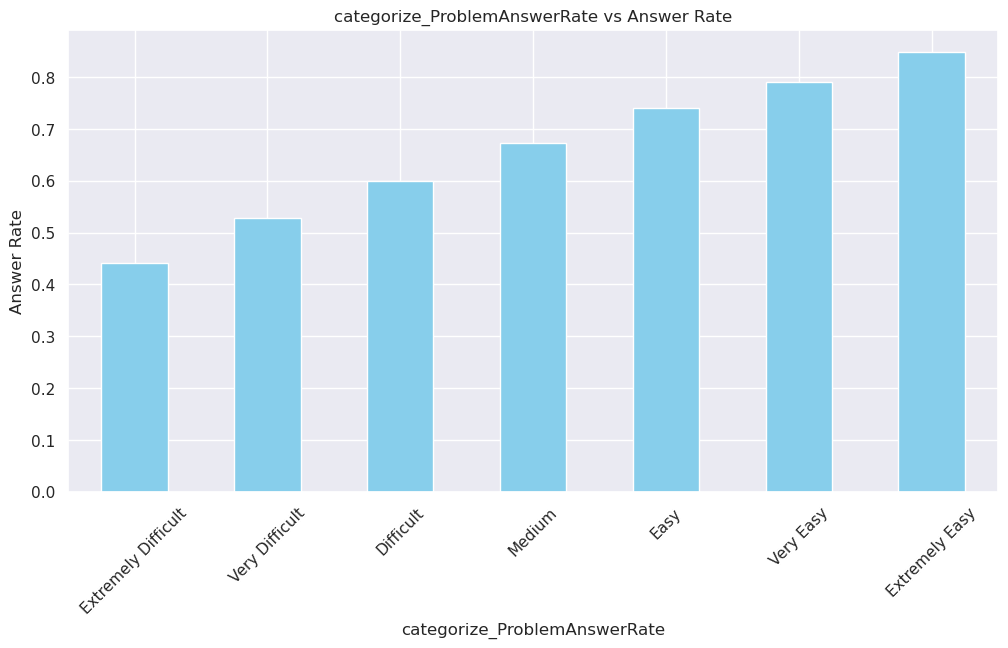

In [117]:
# 범주별 정답률 계산
category_answer_rate = train.groupby('categorize_TagAnswerRate')['answerCode'].mean()
difficulty = ['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy']
category_answer_rate = category_answer_rate.loc[difficulty]


# 그래프 시각화
plt.figure(figsize=(12, 6))
category_answer_rate.plot(kind='bar', color='skyblue')
plt.xlabel('categorize_ProblemAnswerRate')
plt.ylabel('Answer Rate')
plt.title('categorize_ProblemAnswerRate vs Answer Rate')
plt.xticks(rotation=45)

plt.show()

## 시각화를 통한 EDA 결과 확인

## 4.Test 난이도 범주화
범주화해서 새로 열 생성

In [118]:
def categorize_TestAnswerRate(df):
    # TestAnswerRate 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_TestAnswerRate'] = pd.qcut(df['TestAnswerRate'], q=7, labels=['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy'])
    return df

train = categorize_TestAnswerRate(train)
test = categorize_TestAnswerRate(test)

## 시각화를 통한 EDA 결과 확인


/tmp/ipykernel_100324/4291001081.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  categorize_TestAnswerRate = train.groupby('categorize_TestAnswerRate')['answerCode'].mean()


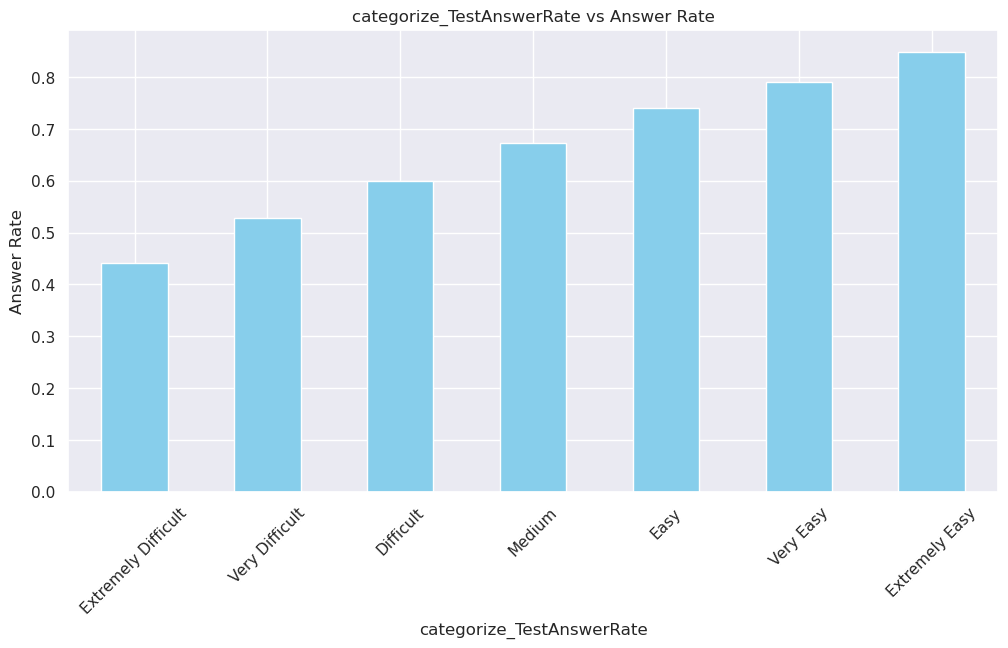

In [119]:
# 범주별 정답률 계산
categorize_TestAnswerRate = train.groupby('categorize_TestAnswerRate')['answerCode'].mean()
difficulty = ['Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy']
categorize_TestAnswerRate = categorize_TestAnswerRate.loc[difficulty]


# 그래프 시각화
plt.figure(figsize=(12, 6))
category_answer_rate.plot(kind='bar', color='skyblue')
plt.xlabel('categorize_TestAnswerRate')
plt.ylabel('Answer Rate')
plt.title('categorize_TestAnswerRate vs Answer Rate')
plt.xticks(rotation=45)

plt.show()

## 결과확인

In [120]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,SolvingTime,CumulativeTime,Month,DayOfWeek,...,CumulativeUserProblemAnswerRate,CumulativeProblemCount,ProblemAnswerRate,TagAnswerRate,CumulativeUserTagAnswerRate,TestAnswerRate,categorize_solvingTime,categorize_ProblemAnswerRate,categorize_TagAnswerRate,categorize_TestAnswerRate
0,0,060001001,060001,1,2020-03-24 00:17:11,7224,3,3,3,Tuesday,...,50,0,98,95,50,95,0,Extremely Easy,Extremely Easy,Extremely Easy
1,0,060001002,060001,1,2020-03-24 00:17:14,7225,8,11,3,Tuesday,...,100,1,96,91,50,95,1,Extremely Easy,Extremely Easy,Extremely Easy
2,0,060001003,060001,1,2020-03-24 00:17:22,7225,7,18,3,Tuesday,...,100,2,91,91,100,95,1,Extremely Easy,Extremely Easy,Extremely Easy
3,0,060001004,060001,1,2020-03-24 00:17:29,7225,7,25,3,Tuesday,...,100,3,97,91,100,95,1,Extremely Easy,Extremely Easy,Extremely Easy
4,0,060001005,060001,1,2020-03-24 00:17:36,7225,11,36,3,Tuesday,...,100,4,94,91,100,95,2,Extremely Easy,Extremely Easy,Extremely Easy


# 새로운 CSV 파일 생성

In [121]:
# answerCode 복구
# train['answerCode'] = train['answerCode'].apply(lambda x: -1 if x == 0.5 else x)

# EDA 파일명
new_csv_name = "FE_v4_1.csv"
new_csv_path = os.path.join(data_path, new_csv_name)

new_csv_name2 = "FE_Test_v4_1.csv"
new_csv_path2 = os.path.join(data_path, new_csv_name2)
# 데이터프레임을 CSV 파일로 저장
train.to_csv(new_csv_path, index=False)
test.to_csv(new_csv_path2, index=False)

print(f"총 {len(train.columns)}개의 Feature가 있습니다.")
print(f"총 {len(test.columns)}개의 Feature가 있습니다.")
print(new_csv_name + " has been made")

총 24개의 Feature가 있습니다.
총 24개의 Feature가 있습니다.
FE_v4_1.csv has been made
